This notebook should be run on linux-hosted environment, as I could not read .tiff files from dataset on windows installation of Anaconda

In [1]:
import os

from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn

from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# http://mathieu.delalandre.free.fr/projects/sesyd/symbols/floorplans.html
!wget -nc http://mathieu.delalandre.free.fr/projects/sesyd/symbols/floorplans/floorplans16-01.zip
!unzip -q -o -d data/ floorplans16-01.zip

DATA_DIR = 'data/'
print(os.listdir(DATA_DIR))

--2020-07-06 13:15:17--  http://mathieu.delalandre.free.fr/projects/sesyd/symbols/floorplans/floorplans16-01.zip
Resolving mathieu.delalandre.free.fr (mathieu.delalandre.free.fr)... 212.27.63.105, 212.27.60.20, 212.27.60.19
Connecting to mathieu.delalandre.free.fr (mathieu.delalandre.free.fr)|212.27.63.105|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6281557 (6.0M) [application/zip]
Saving to: ‘floorplans16-01.zip’

floorplans16-01.zip 100%[===================>]   5.99M  1.72MB/s    in 3.5s    

2020-07-06 13:15:21 (1.72 MB/s) - ‘floorplans16-01.zip’ saved [6281557/6281557]

['floorplans16-01']


In [3]:
image_size = 64
batch_size = 16
#stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
stats = (1, 1, 1), (1, 1, 1)

transform = tt.Compose([
    tt.Grayscale(num_output_channels=1),
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    #tt.Normalize(*stats),
])

train_ds = ImageFolder(DATA_DIR, transform = transform)

In [4]:
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 0, pin_memory = True)

In [5]:
#def denorm(img_tensors):
#    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax = 16):
    fig, ax = plt.subplots(figsize = (16,16))
    ax.set_xticks([])
    ax.set_yticks([])
    denrom_batch = images.detach()[:nmax]
    grid = make_grid(denrom_batch, nrow = 4).permute(1,2,0)
    # print(torch.max(grid))
    ad = (grid*255).byte()
    ax.imshow(ad)

def show_batch(dl, nmax = 16)    :
    for images, _ in dl:
        show_images(images, nmax)
        break

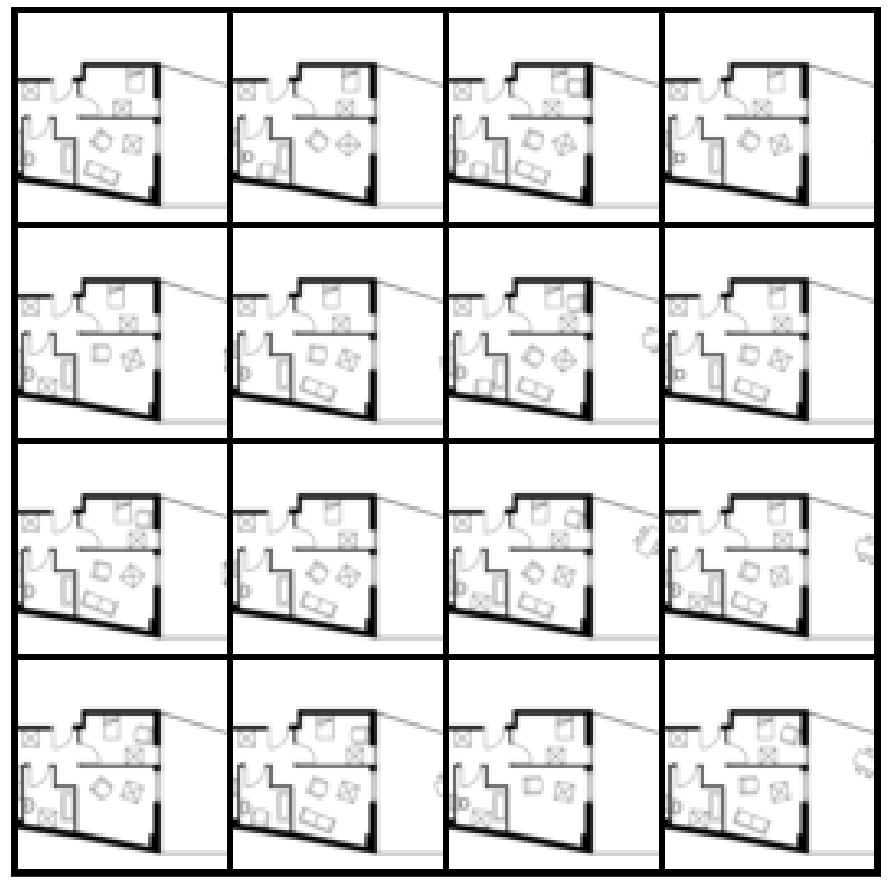

In [6]:
show_batch(train_dl)

In [7]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking = True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device  = device
        
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
    
    def __len__(self):
        return len(self.dl)
    
        

In [8]:
device = get_default_device()
device

device(type='cpu')

In [9]:
train_dl = DeviceDataLoader(train_dl, device)

In [10]:
discriminator = nn.Sequential(
    nn.Linear(image_size, 64),
    
    #in: 1x64x64
    nn.Conv2d(1, 64, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.1, inplace = True),
    #out: 64x32x32
    
    nn.Conv2d(64, 128, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.1, inplace = True),
    #out: 128x16x16
    
    nn.Conv2d(128, 256, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.1, inplace = True),
    #out: 256x8x8
    
    nn.Conv2d(256, 512, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.1, inplace = True),
    #out: 512x4x4
    
    nn.Conv2d(512, 1, kernel_size = 4, stride = 1, padding = 0, bias = False),
    
    #out: 1x1x1
    
    nn.Flatten(),
    nn.Sigmoid()
)

discriminator = to_device(discriminator,device)

In [11]:
# test output shape of discriminator
for real_images, _ in tqdm(train_dl):
    print (real_images.shape)
    d = discriminator(to_device(real_images,device))
    print(d.shape)
    break

torch.Size([16, 1, 64, 64])
torch.Size([16, 1])


In [12]:
latent_size = 16

In [13]:
import math

num_layers =  int(math.log(image_size / 8,2))
print(num_layers)
startsize = int(64*2**num_layers)
generator = nn.Sequential(
    #in: latent_size x 1 x 1
    nn.ConvTranspose2d(latent_size, startsize, kernel_size = 4, stride = 1, padding = 0, bias = False),
    nn.BatchNorm2d(startsize),
    nn.ReLU(True)
    )
a=startsize

for i in reversed(range(num_layers)):
    b = a // 2
    generator.add_module("convtranspose2d"+str(i), nn.ConvTranspose2d(a,b,kernel_size=4, stride=2, padding=1,bias=False))
    generator.add_module("batchnorm"+str(i),nn.BatchNorm2d(b))
    generator.add_module("relu"+str(i),nn.ReLU(True))
    a //= 2

generator.add_module("lastconv",nn.ConvTranspose2d(64, 1, kernel_size= 4, stride= 2, padding= 1, output_padding= 0, bias = False))
generator.add_module("tanh",nn.Tanh())

generator = to_device(generator, device)
print(generator)

3
Sequential(
  (0): ConvTranspose2d(16, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (convtranspose2d2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batchnorm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace=True)
  (convtranspose2d1): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batchnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace=True)
  (convtranspose2d0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batchnorm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu0): ReLU(inplace=True)
  (lastconv): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(

torch.Size([16, 1, 64, 64]) tensor(1.0000, grad_fn=<MaxBackward1>)
torch.Size([16, 1])


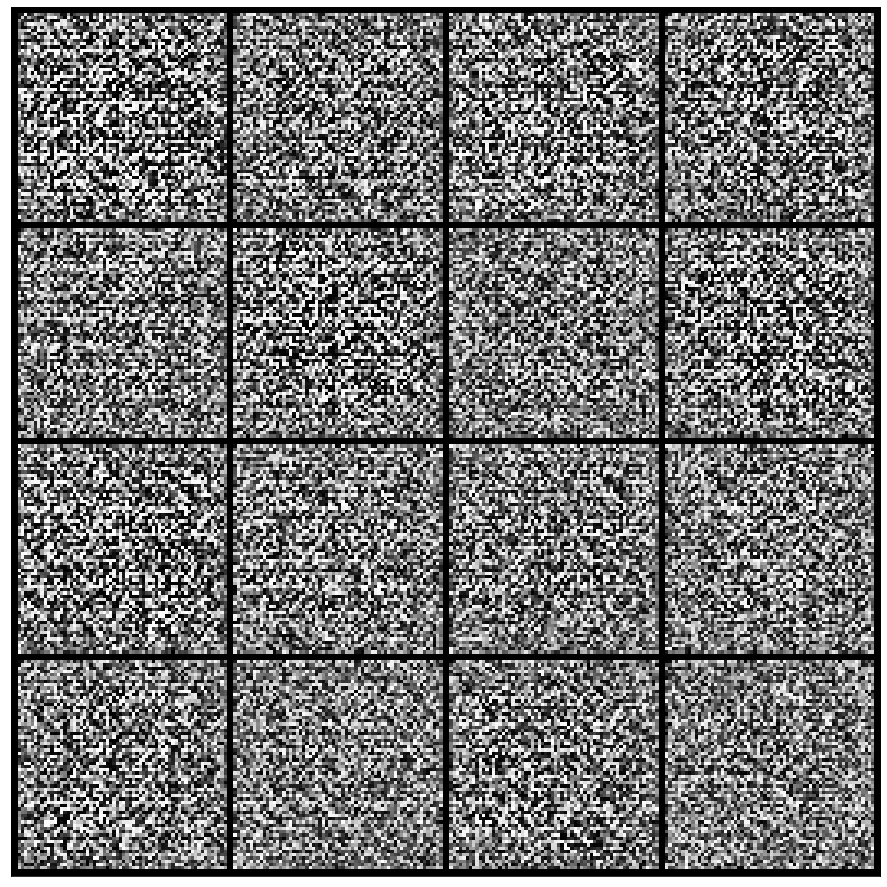

In [14]:
latent = torch.randn(batch_size, latent_size, 1, 1, device = device)
fake_images = generator(latent)
print(fake_images.shape, torch.max(fake_images))
show_images(fake_images.cpu())

fake_preds = discriminator(fake_images)
print(fake_preds.shape)

In [15]:
def train_discriminator(real_images, opt_d):
    # clear grad
    opt_d.zero_grad()
    
    # pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device = device)

    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device = device)
    fake_images = generator(latent)
    
    # pass fake images through discriminator
    fake_targetes = torch.zeros(fake_images.size(0), 1, device = device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targetes)
    fake_score = torch.mean(fake_preds).item()
    
    # update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    
    return loss.item(), real_score, fake_score

In [16]:
def train_generator(opt_g):
    # clear generator gradients
    opt_g.zero_grad()
    
    # generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device = device)
    fake_images = generator(latent)
    
    # try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device = device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [17]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok = True)

def save_samples(index, latent_tensors, show= False):
    fake_images = generator(latent_tensors).cpu()
    fake_filename = 'generated-{0:0=4d}.png'.format(index)
    # print(fake_images.shape, torch.max(fake_images))
    
    filename = os.path.join(sample_dir, fake_filename)
    save_image(fake_images, filename, nrow = 4)
    # print("Saving ", fake_filename)
    if show:
        show_images(fake_images)

In [18]:
fixed_latent = torch.randn(image_size, latent_size, 1, 1, device = device)
#save_samples(0, fixed_latent,  True)

In [19]:
def fit(epochs, lr, start_idx = 1):
    torch.cuda.empty_cache()
    
    # losses and scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # create oprimizeres
    opt_d = torch.optim.Adam(discriminator.parameters(), lr = lr/15, weight_decay=0.89, betas = (0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr = lr, weight_decay=0.79,  betas = (0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            
            # train generator
            loss_g =  train_generator(opt_g)
            
            # record losses and scores
            
            losses_g.append(loss_g)
            losses_d.append(loss_d)
            real_scores.append(real_score)
            fake_scores.append(fake_score)
            
            # pring losses and scores
            message_template = "Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}"
            print(message_template.format(
                epoch + 1,
                epochs,
                loss_g,
                loss_d,
                real_score,
                fake_score
            ))
            
            save_samples(epoch+start_idx, fixed_latent, show = False)
            
    return losses_g, losses_d, real_scores, fake_scores

In [20]:
lr = 5e-6
epochs = 5

history = fit(epochs, lr)
losses_g, losses_d, real_scores, fake_scores = history

Epoch [1/5], loss_g: 0.7517, loss_d: 1.6009, real_score: 0.3902, fake_score: 0.4757
Epoch [1/5], loss_g: 0.7272, loss_d: 1.5925, real_score: 0.3996, fake_score: 0.4854
Epoch [1/5], loss_g: 0.7484, loss_d: 1.6166, real_score: 0.4116, fake_score: 0.5101
Epoch [1/5], loss_g: 0.6492, loss_d: 1.5843, real_score: 0.4104, fake_score: 0.4954
Epoch [1/5], loss_g: 0.6571, loss_d: 1.6090, real_score: 0.4188, fake_score: 0.5190
Epoch [1/5], loss_g: 0.6454, loss_d: 1.5891, real_score: 0.4222, fake_score: 0.5090
Epoch [1/5], loss_g: 0.6630, loss_d: 1.5675, real_score: 0.4286, fake_score: 0.5087



Epoch [2/5], loss_g: 0.6581, loss_d: 1.5743, real_score: 0.4342, fake_score: 0.5177
Epoch [2/5], loss_g: 0.5981, loss_d: 1.5786, real_score: 0.4370, fake_score: 0.5196
Epoch [2/5], loss_g: 0.5762, loss_d: 1.6189, real_score: 0.4416, fake_score: 0.5443
Epoch [2/5], loss_g: 0.6021, loss_d: 1.5475, real_score: 0.4502, fake_score: 0.5212
Epoch [2/5], loss_g: 0.6424, loss_d: 1.6597, real_score: 0.4542, fake_score: 0.5742
Epoch [2/5], loss_g: 0.5708, loss_d: 1.6414, real_score: 0.4580, fake_score: 0.5720
Epoch [2/5], loss_g: 0.5475, loss_d: 1.5872, real_score: 0.4686, fake_score: 0.5577



Epoch [3/5], loss_g: 0.5769, loss_d: 1.5710, real_score: 0.4716, fake_score: 0.5536
Epoch [3/5], loss_g: 0.5188, loss_d: 1.5755, real_score: 0.4708, fake_score: 0.5559
Epoch [3/5], loss_g: 0.5826, loss_d: 1.5664, real_score: 0.4779, fake_score: 0.5560
Epoch [3/5], loss_g: 0.5277, loss_d: 1.6335, real_score: 0.4840, fake_score: 0.5910
Epoch [3/5], loss_g: 0.5617, loss_d: 1.6261, real_score: 0.4912, fake_score: 0.5957
Epoch [3/5], loss_g: 0.5467, loss_d: 1.6112, real_score: 0.4898, fake_score: 0.5864
Epoch [3/5], loss_g: 0.5280, loss_d: 1.5791, real_score: 0.5062, fake_score: 0.5897



Epoch [4/5], loss_g: 0.5392, loss_d: 1.7480, real_score: 0.4990, fake_score: 0.6404
Epoch [4/5], loss_g: 0.5018, loss_d: 1.5591, real_score: 0.5099, fake_score: 0.5843
Epoch [4/5], loss_g: 0.5063, loss_d: 1.5206, real_score: 0.5148, fake_score: 0.5683
Epoch [4/5], loss_g: 0.5199, loss_d: 1.5993, real_score: 0.5182, fake_score: 0.6061
Epoch [4/5], loss_g: 0.5195, loss_d: 1.6257, real_score: 0.5181, fake_score: 0.6135
Epoch [4/5], loss_g: 0.4672, loss_d: 1.6563, real_score: 0.5243, fake_score: 0.6279
Epoch [4/5], loss_g: 0.4543, loss_d: 1.6306, real_score: 0.5296, fake_score: 0.6264



Epoch [5/5], loss_g: 0.4896, loss_d: 1.6396, real_score: 0.5372, fake_score: 0.6349
Epoch [5/5], loss_g: 0.4332, loss_d: 1.6849, real_score: 0.5447, fake_score: 0.6567
Epoch [5/5], loss_g: 0.4751, loss_d: 1.7031, real_score: 0.5389, fake_score: 0.6576
Epoch [5/5], loss_g: 0.4489, loss_d: 1.5971, real_score: 0.5429, fake_score: 0.6153
Epoch [5/5], loss_g: 0.4729, loss_d: 1.6894, real_score: 0.5486, fake_score: 0.6572
Epoch [5/5], loss_g: 0.4755, loss_d: 1.6038, real_score: 0.5530, fake_score: 0.6331
Epoch [5/5], loss_g: 0.4336, loss_d: 1.7655, real_score: 0.5592, fake_score: 0.6882



['generated-0001.png', 'generated-0002.png', 'generated-0004.png', 'generated-0003.png', 'generated-0005.png']


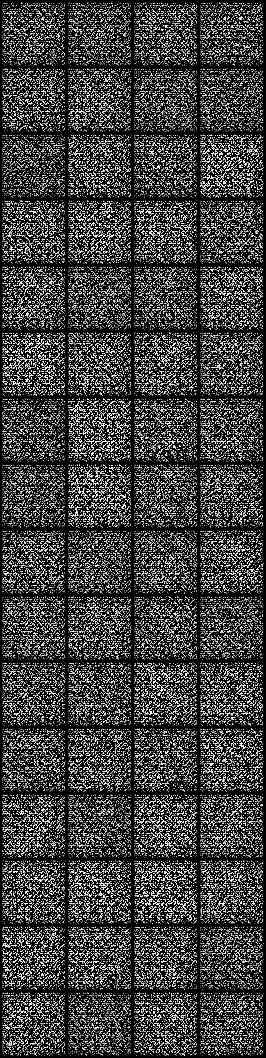

In [21]:
print(os.listdir('generated/'))
from IPython.display import Image
Image('generated/generated-{:04d}.png'.format(epochs))



Text(0.5, 1.0, 'Losses')

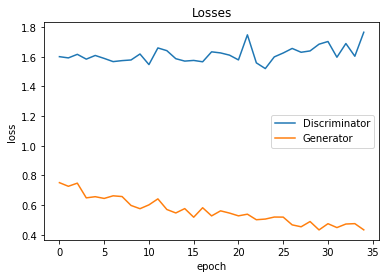

In [22]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses')

Text(0.5, 1.0, 'Scores')

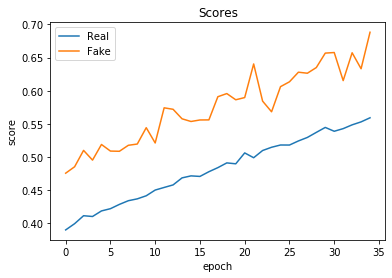

In [23]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores')